### **Importing Libraries**


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

### **Web scraping the NYC TLC Trip record webpage**

In [2]:
##Current version


import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the TLC Trip Record Data page
url = 'https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page'

# Send a GET request
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the links (you need to update the selector based on the actual page structure)
links = soup.find_all('a')

# Filter links for Yellow Taxi and a specific year, adjust the conditions based on actual link text or URL structure
yellow_taxi_links = [link['href'] for link in links if 'yellow' in link['href'] and '2023' in link['href']]  # Considering data for 2023


In [3]:
yellow_taxi_links

['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-05.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-07.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-08.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-09.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-10.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-11.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023

Collected the links of NYC TLC Taxi trip data for each month of 2023.

In [4]:
from pathlib import Path

from typing import Optional, List, Tuple

def extract_one_file_of_raw_data(url) -> Path:
    """
    Extract Parquet file with historical taxi rides for the links we obatined in the above step
    """
    url_lst = url.split('/')
    URL = url_lst[0]+'/' + url_lst[1] +'/'+  url_lst[2]+'/' + url_lst[3] + '/'+ url_lst[4]
    URL = URL.strip()
    response = requests.get(URL)

    if response.status_code == 200:
        fname = URL.split('/')[4]
        path = fname
        open(path, "wb").write(response.content)
        return path
    else:
        raise Exception(f'{URL} is not available')

fnames =  []

#Extracting first and second month (January, February and March) of the Trip Data 2023

for url in yellow_taxi_links[0:3]:
  fname = extract_one_file_of_raw_data(url)
  fnames.append(fname)


fnames




['yellow_tripdata_2023-01.parquet',
 'yellow_tripdata_2023-02.parquet',
 'yellow_tripdata_2023-03.parquet']

Extracted and saved two months (January and February) of trip data in 2023

In [5]:
def extract_year_month(fname) -> Tuple:
  year, month = fname.split('_')[2].split('.')[0].split('-')
  return int(year),int(month)



In [6]:
def validate_raw_data(
    rides: pd.DataFrame,
    year: int,
    month: int,
) -> pd.DataFrame:
    """
    Removes rows with pickup_datetimes outside their valid range
    """
    # keep only rides for this month
    this_month_start = f'{year}-{month}-01'
    next_month_start = f'{year}-{month+1}-01' if month < 12 else f'{year+1}-01-01'
    rides = rides[rides.pickup_datetime >= this_month_start]
    rides = rides[rides.pickup_datetime < next_month_start]

    return rides

In [7]:
def load_raw_data() -> pd.DataFrame:
    """
    Loads raw data from local storage or downloads it from the NYC website, and
    then loads it into a Pandas DataFrame

    Args:
        year: year of the data to download
        months: months of the data to download. If `None`, download all months

    Returns:
        pd.DataFrame: DataFrame with the following columns:
            - pickup_datetime: datetime of the pickup
            - pickup_location_id: ID of the pickup location
    """
    rides = pd.DataFrame()


    for file in fnames:

        # load the file into Pandas
        rides_one_month = pd.read_parquet(file)

        # rename columns
        #rides_one_month = rides_one_month[['tpep_pickup_datetime', 'PULocationID']]

        rides_one_month.columns = [col.lower()  for col in rides_one_month.columns]

        rides_one_month.rename(columns={
            'tpep_pickup_datetime': 'pickup_datetime',
            'pulocationid': 'pickup_location_id',
        }, inplace=True)

        year,month = extract_year_month(file)

        # validate the file
        rides_one_month = validate_raw_data(rides_one_month, year, month)

        # append to existing data
        rides = pd.concat([rides, rides_one_month])

    if rides.empty:
        # no data, so we return an empty dataframe
        return pd.DataFrame()
    else:
        # keep only time and origin of the ride
        #rides = rides[['pickup_datetime', 'pickup_location_id']]
        return rides


In [8]:
nyc_data = load_raw_data()

In [9]:
nyc_data.shape

(9384195, 19)

**First two months of 2023 year has around 5.98 Million trips**

First three months of 2023 year has around 9.38 Million trips

In [10]:
nyc_data.head()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [11]:
nyc_data.dtypes

vendorid                          int64
pickup_datetime          datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
ratecodeid                      float64
store_and_fwd_flag               object
pickup_location_id                int64
dolocationid                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

### **Missing Values Analysis**

In [12]:
(nyc_data.isnull().sum()* 100)/ nyc_data.shape[0]

vendorid                 0.000000
pickup_datetime          0.000000
tpep_dropoff_datetime    0.000000
passenger_count          2.516774
trip_distance            0.000000
ratecodeid               2.516774
store_and_fwd_flag       2.516774
pickup_location_id       0.000000
dolocationid             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     2.516774
airport_fee              2.516774
dtype: float64

The dataset exhibits a consistent pattern with minimal missing data across most columns. Nevertheless, passenger_count, ratecodeid, store_and_fwd_flag, congestion_surcharge, and airport_fee all exhibit a 2.484% rate of missing values. This suggests that these fields may have been optional or not applicable for every entry in the dataset. Properly addressing missing values is crucial during the data preprocessing stage prior to any analysis or modeling.

In [13]:
nyc_data.shape

(9384195, 19)

**Rows containing Nans and needs cleaning**

In [14]:
nyc_data[nyc_data['passenger_count'].isna()].head()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2995023,1,2023-01-01 00:02:40,2023-01-01 00:30:36,NaN,0.00,NaN,None,142,79,0,20.13,0.0,0.5,0.00,0.0,1.0,24.13,NaN,NaN
2995024,1,2023-01-01 00:57:48,2023-01-01 01:12:34,NaN,0.00,NaN,None,237,263,0,12.00,1.0,0.5,2.55,0.0,1.0,21.55,NaN,NaN
2995025,2,2023-01-01 00:55:37,2023-01-01 01:00:41,NaN,0.86,NaN,None,24,41,0,12.80,0.0,0.5,2.14,0.0,1.0,16.44,NaN,NaN
2995026,2,2023-01-01 00:43:47,2023-01-01 00:56:12,NaN,5.36,NaN,None,88,229,0,24.51,0.0,0.5,4.28,0.0,1.0,32.79,NaN,NaN
2995027,2,2023-01-01 00:34:00,2023-01-01 00:51:00,NaN,6.03,NaN,None,232,263,0,32.30,0.0,0.5,7.26,0.0,1.0,43.56,NaN,NaN


In [15]:
nyc_data[nyc_data['passenger_count'].isna()]

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2995023,1,2023-01-01 00:02:40,2023-01-01 00:30:36,NaN,0.00,NaN,None,142,79,0,20.13,0.0,0.5,0.00,0.0,1.0,24.13,NaN,NaN
2995024,1,2023-01-01 00:57:48,2023-01-01 01:12:34,NaN,0.00,NaN,None,237,263,0,12.00,1.0,0.5,2.55,0.0,1.0,21.55,NaN,NaN
2995025,2,2023-01-01 00:55:37,2023-01-01 01:00:41,NaN,0.86,NaN,None,24,41,0,12.80,0.0,0.5,2.14,0.0,1.0,16.44,NaN,NaN
2995026,2,2023-01-01 00:43:47,2023-01-01 00:56:12,NaN,5.36,NaN,None,88,229,0,24.51,0.0,0.5,4.28,0.0,1.0,32.79,NaN,NaN
2995027,2,2023-01-01 00:34:00,2023-01-01 00:51:00,NaN,6.03,NaN,None,232,263,0,32.30,0.0,0.5,7.26,0.0,1.0,43.56,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403761,2,2023-03-31 23:24:25,2023-03-31 23:40:54,NaN,3.16,NaN,None,163,75,0,12.13,0.0,0.5,4.23,0.0,1.0,20.36,NaN,NaN
3403762,2,2023-03-31 23:24:50,2023-04-01 00:04:12,NaN,6.89,NaN,None,125,198,0,40.92,0.0,0.5,8.98,0.0,1.0,53.90,NaN,NaN
3403763,2,2023-03-31 23:26:31,2023-03-31 23:49:39,NaN,4.01,NaN,None,50,224,0,24.02,0.0,0.5,0.00,0.0,1.0,28.02,NaN,NaN
3403764,2,2023-03-31 23:07:51,2023-03-31 23:15:56,NaN,1.31,NaN,None,113,158,0,8.51,0.0,0.5,3.50,0.0,1.0,16.01,NaN,NaN


In [16]:
nyc_data.dropna(inplace=True)

In [17]:
(nyc_data.isnull().sum()* 100)/ nyc_data.shape[0]

vendorid                 0.0
pickup_datetime          0.0
tpep_dropoff_datetime    0.0
passenger_count          0.0
trip_distance            0.0
ratecodeid               0.0
store_and_fwd_flag       0.0
pickup_location_id       0.0
dolocationid             0.0
payment_type             0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
congestion_surcharge     0.0
airport_fee              0.0
dtype: float64

### **Analysing Passenger Count Feature**

<Axes: xlabel='passenger_count', ylabel='count'>

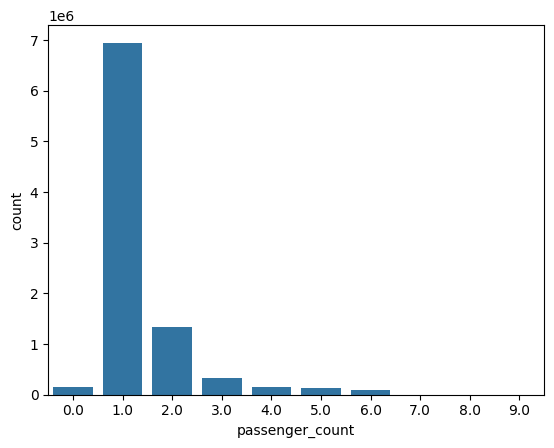

In [18]:
sns.countplot(x="passenger_count",data=nyc_data)

The bar representing a passenger_count of 1 has the highest value, suggesting that solo rides are the most frequent.

There is a noticable decline in the frequency as the number of passengers grow.

As per the NYC TLC law, maximum passengers are limited to 4 or 5 based on the type of cab.

This plot facilitates a rapid understanding of the average passenger count per journey, hence exerting an impact on decisions about the taxi fleets and the provision of services.




Based on the analysis, it is evident that removing rows with a passenger count of 0 or greater than 5 would be beneficial for predictive analysis.

In [19]:
nyc_data[(nyc_data['passenger_count'] == 0) | (nyc_data['passenger_count'] >= 6)].count()

vendorid                 240940
pickup_datetime          240940
tpep_dropoff_datetime    240940
passenger_count          240940
trip_distance            240940
ratecodeid               240940
store_and_fwd_flag       240940
pickup_location_id       240940
dolocationid             240940
payment_type             240940
fare_amount              240940
extra                    240940
mta_tax                  240940
tip_amount               240940
tolls_amount             240940
improvement_surcharge    240940
total_amount             240940
congestion_surcharge     240940
airport_fee              240940
dtype: int64

In [20]:
nyc_data['vendorid'].value_counts()

vendorid
2    6659336
1    2488680
Name: count, dtype: int64

In [21]:
nyc_data.describe()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,9.148016e+06,9148016,9148016,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06,9.148016e+06
mean,1.727954e+00,2023-02-16 05:19:44.511679,2023-02-16 05:35:54.200296,1.355501e+00,3.424434e+00,1.548613e+00,1.660647e+02,1.643736e+02,1.218957e+00,1.845866e+01,1.613087e+00,4.875830e-01,3.415021e+00,5.344520e-01,9.813128e-01,2.722273e+01,2.278024e+00,1.028826e-01
min,1.000000e+00,2023-01-01 00:00:05,2023-01-01 00:03:28,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-9.599000e+02,-7.500000e+00,-5.000000e-01,-9.622000e+01,-7.330000e+01,-1.000000e+00,-9.829500e+02,-2.500000e+00,-1.250000e+00
25%,1.000000e+00,2023-01-24 22:27:08,2023-01-24 22:40:44,1.000000e+00,1.050000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.548000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2023-02-16 14:42:35,2023-02-16 14:59:08,1.000000e+00,1.770000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.800000e+00,0.000000e+00,1.000000e+00,2.016000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2023-03-10 14:10:58.250000,2023-03-10 14:29:28,1.000000e+00,3.300000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.200000e+00,0.000000e+00,1.000000e+00,2.892000e+01,2.500000e+00,0.000000e+00
max,2.000000e+00,2023-03-31 23:59:59,2023-04-01 23:48:28,9.000000e+00,6.235952e+04,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,2.203100e+03,1.375000e+01,5.316000e+01,9.843000e+02,1.969900e+02,1.000000e+00,2.208100e+03,2.750000e+00,1.250000e+00
std,4.450134e-01,NaN,NaN,8.903780e-01,3.271001e+01,6.855989e+00,6.378891e+01,6.975425e+01,5.018413e-01,1.796969e+01,1.815972e+00,1.032489e-01,3.910334e+00,2.060429e+00,1.885032e-01,2.244286e+01,7.694509e-01,3.485940e-01


In [22]:
exclude_indexes = nyc_data[(nyc_data['passenger_count'] == 0) | (nyc_data['passenger_count'] >= 6)].index
nyc_data.drop(exclude_indexes, inplace=True)
display(nyc_data.shape)
nyc_data.head(10)

(8468564, 19)

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.00,0.0,1.0,14.30,2.5,0.0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.00,0.0,1.0,16.90,2.5,0.0
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,12.8,1.0,0.5,10.00,0.0,1.0,27.80,2.5,0.0
6,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,12.1,1.0,0.5,3.42,0.0,1.0,20.52,2.5,0.0
7,2,2023-01-01 00:27:12,2023-01-01 00:49:56,1.0,11.70,1.0,N,142,200,1,45.7,1.0,0.5,10.74,3.0,1.0,64.44,2.5,0.0
8,2,2023-01-01 00:21:44,2023-01-01 00:36:40,1.0,2.95,1.0,N,164,236,1,17.7,1.0,0.5,5.68,0.0,1.0,28.38,2.5,0.0
9,2,2023-01-01 00:39:42,2023-01-01 00:50:36,1.0,3.01,1.0,N,141,107,2,14.9,1.0,0.5,0.00,0.0,1.0,19.90,2.5,0.0
10,2,2023-01-01 00:53:01,2023-01-01 01:01:45,1.0,1.80,1.0,N,234,68,1,11.4,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0
11,1,2023-01-01 00:43:37,2023-01-01 01:17:18,4.0,7.30,1.0,N,79,264,1,33.8,3.5,0.5,7.75,0.0,1.0,46.55,2.5,0.0


### **Payment Types**

In [23]:
print("Least Payment Type:",nyc_data['payment_type'].min())
print("Max Payment Type:",nyc_data['payment_type'].max())

Least Payment Type: 1
Max Payment Type: 5


In [24]:
nyc_data['payment_type'].value_counts()


payment_type
1    6862753
2    1456689
4      98100
3      51021
5          1
Name: count, dtype: int64

In [25]:
exclude_indexes_pay = nyc_data[nyc_data['payment_type'] == 5].index
nyc_data.drop(exclude_indexes_pay, inplace=True)

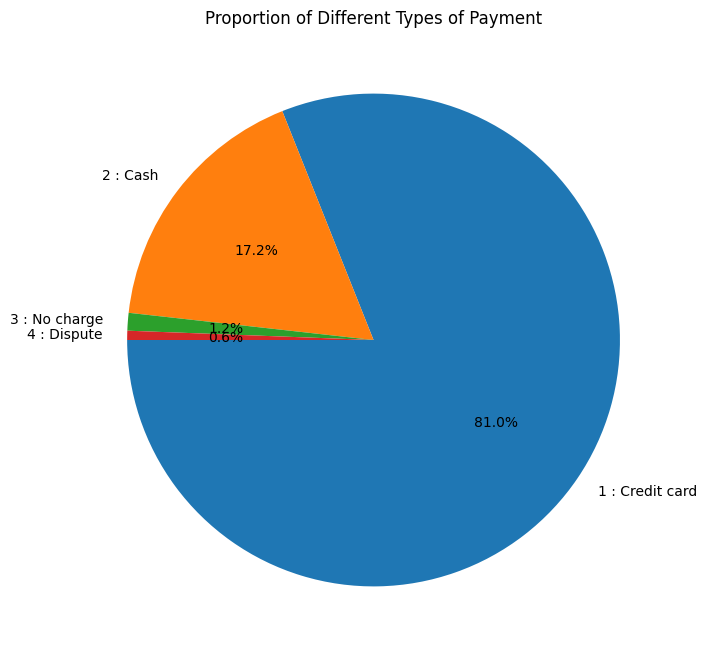

In [26]:
payment_counts = nyc_data['payment_type'].value_counts()

plt.figure(figsize=(8, 8))
labels = ['1 : Credit card',
'2 : Cash',
'3 : No charge',
'4 : Dispute',
]

plt.pie(payment_counts, labels=labels, autopct='%1.1f%%', startangle=180)
plt.title('Proportion of Different Types of Payment')
plt.show()

The data reveals that an important majority, specifically 80.6%, of taxi payments are carried out by credit cards, suggesting a significant trend towards cashless transactions. This phenomenon may be attributed to the perceived convenience and enhanced security offered by card payments, including potential incentives such as rewards points.

The remaining payment types, namely 'No charge' and 'Dispute', constitute a relatively adequate, amounting to 1.1% and 0.5% respectively. The observed low percentages indicate the presence of efficient dispute resolution mechanisms and a limited number of rides that incur no charges.



### **Total Amount**

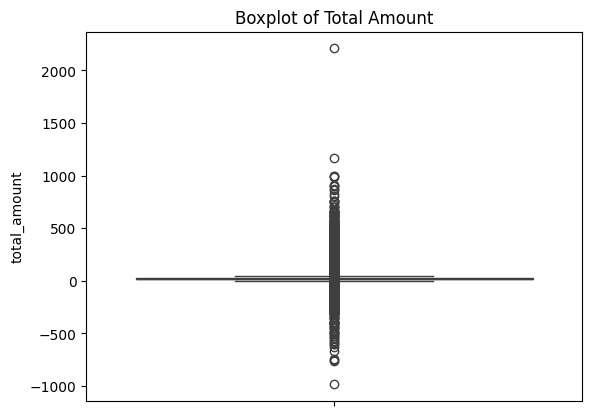

In [27]:
sns.boxplot(y="total_amount", data =nyc_data).set(title='Boxplot of Total Amount')
plt.show()

The boxplot displays the median, which is the central line within the box. It is observed that the median charge amount is rather low, as indicated by its proximity to zero. The interquartile range (IQR), denoted by the length of the box, represents the central 50% of the dataset, showing a tightly clustered distribution around the median.

There exists a significant amount of outliers on both ends of the bandwidth, particularly on the positive side, beyond the threshold of \$ 1,000. These outliers may suggest the presence of exceptionally lengthy journeys, potential inaccuracies in the data, or trips with atypical prices. Negative figures, such as outliers below -$500, may indicate inaccurate data entry, refunds, or other modifications.

In [28]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100
print('-------------------------------------------------------------------------')
print('Analysing total amount feature of every ride')

for i in range(0,10):
    var = nyc_data["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))

for i in range(10,100,10):
    var = nyc_data["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
#print("100 percentile value is ",var[-1])

#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(91,100):
    var = nyc_data["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
#print("100 percentile value is ",var[-1])

for i in np.arange(0.0, 1.0, 0.1):
    var =nyc_data["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

-------------------------------------------------------------------------
Analysing total amount feature of every ride
0 percentile value is -982.95
1 percentile value is 4.5
2 percentile value is 9.1
3 percentile value is 10.0
4 percentile value is 10.5
5 percentile value is 10.92
6 percentile value is 11.38
7 percentile value is 11.76
8 percentile value is 11.9
9 percentile value is 12.25
10 percentile value is 12.6
20 percentile value is 14.64
30 percentile value is 16.4
40 percentile value is 18.2
50 percentile value is 20.16
60 percentile value is 22.75
70 percentile value is 26.4
80 percentile value is 32.76
90 percentile value is 56.4
91 percentile value is 61.15
92 percentile value is 65.56
93 percentile value is 70.2
94 percentile value is 75.13
95 percentile value is 80.55
96 percentile value is 85.62
97 percentile value is 91.8
98 percentile value is 97.91
99 percentile value is 102.25
99.0 percentile value is 102.25
99.1 percentile value is 103.1
99.2 percentile value is 10

The fare range is broad, with a negative minimum value of -$751, indicating the presence of data anomalies such as refunds or input errors.

Indicating an abundance of short trips or minimal charges, the fares are quite low up to the 10th percentile.

 The central trend of travel costs is shown by the median fare at the 50th percentile, which is $20.1.

 A significant increase in fares is observed as one moves from the 90th percentile upwards, with the 99th percentile nearly tripling to $101.94. This indicates that a minority of journeys incur considerably greater expenses.

 The ticket numbers observed in the 100th percentile (\$1169.4) are indicative of potential outliers or unusual instances.


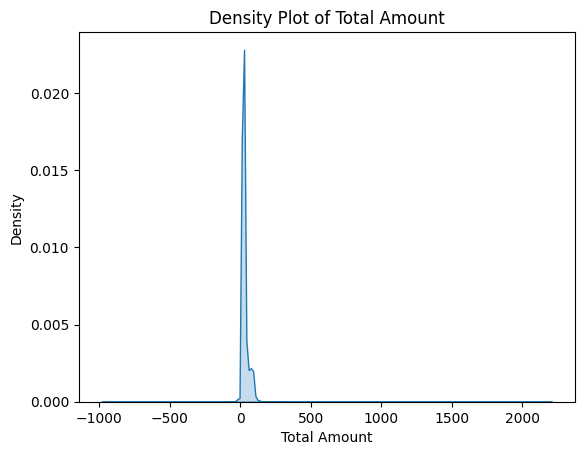

In [29]:
sns.kdeplot(nyc_data['total_amount'], fill=True)
plt.xlabel('Total Amount')
plt.ylabel('Density')
plt.title("Density Plot of Total Amount")
plt.show()

- Most taxi rides have fares that are below the average, with a large number of small transactions.

- There is a significant number of outliers, particularly on the higher end, indicating the possibility of longer, more expensive rides or potential data errors.

- The negative values are worth investigating as they may indicate data entry errors or specific cases such as fare refunds. When it comes to data cleaning, it's important to carefully evaluate these entries and either remove them or gain a deeper understanding of their context.

- When conducting in-depth analysis, particularly for predictive modeling, it is important to consider how to handle outliers and negative values. This can be done through exclusion, transformation, or gaining a better understanding of their business context.

- For a more comprehensive analysis of the data, it would be beneficial to consider transforming the data (such as using a log scale) or excluding outliers that could potentially distort the results.

In [30]:
#Based on the box plot, setting the min_amt should be greater than 0 and max_amt should be less than 700

# Filtering the negative and the most extreme values based on the percentile distribution we've observed
nyc_data = nyc_data[(nyc_data['total_amount'] > 0) & (nyc_data['total_amount'] <  500)]


In [31]:
nyc_data.shape

(8391353, 19)

### **Vendor ID**

As per NY Authority rule, there are only 2 Vendors.

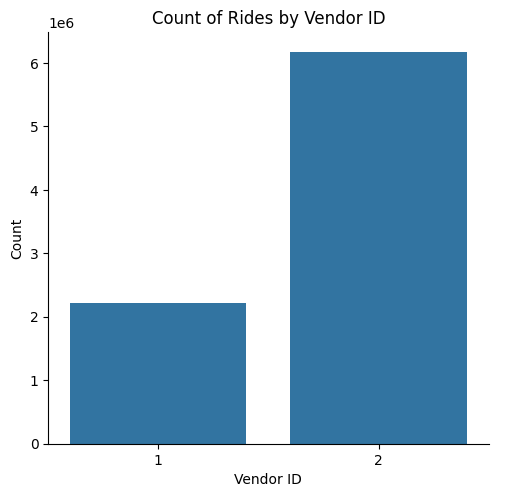

In [32]:
sns.catplot(x='vendorid', kind='count', data=nyc_data)

plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.title('Count of Rides by Vendor ID')
plt.show()

There are no anomalies in this feature

### **PULocationID and DOLocationID**

In [33]:
nyc_data[(nyc_data['pickup_location_id']<1) & (nyc_data['pickup_location_id']>265)]

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee


From the above observation, there are no outliers.

### **Pickup time and Drop off Time**

In [34]:
nyc_data[(nyc_data['tpep_dropoff_datetime'] > '2023-02-01 12:00:00') & (nyc_data['pickup_datetime'] < '2023-01-01 12:00:00')]

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee


 we have no aberrations in the analyzed month of the dataset

### **Feature Engineering**

**Trip Duration** and **Average Speed during the ride**



In [35]:

def get_trip_duration_speed(month_data):
    # Convert pickup and dropoff to datetime, and then to Unix time directly using pandas
    month_data['pickup_datetime'] = pd.to_datetime(month_data['pickup_datetime'])
    month_data['tpep_dropoff_datetime'] = pd.to_datetime(month_data['tpep_dropoff_datetime'])

    # Calculate duration of trips in minutes
    month_data['trip_duration(mins)'] = round((month_data['tpep_dropoff_datetime'] - month_data['pickup_datetime']).dt.total_seconds() / 60.0,2)


    # Only include rows where the duration is positive
    month_data = month_data[month_data['trip_duration(mins)'] > 0]

    # Calculate speed in miles per hour
    month_data['avg_speed(mph)'] = round(60 * (month_data['trip_distance'] / month_data['trip_duration(mins)']),2)


    return month_data

print(nyc_data.shape)
nyc_data_eng  = get_trip_duration_speed(nyc_data)


(8391353, 19)


<ipython-input-35-1bbfa2e88bbc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_data['avg_speed(mph)'] = round(60 * (month_data['trip_distance'] / month_data['trip_duration(mins)']),2)


The function "get_trip_duration_speed" is responsible for conducting feature engineering on a provided DataFrame named "month_data," which encompasses information related to taxi trips. Feature engineering refers to the systematic utilisation of domain knowledge to generate novel features from unprocessed data, hence enhancing the performance of machine learning algorithms. The function performs the following actions:

1. **Datetime Conversion**: The 'pickup_datetime' and 'tpep_dropoff_datetime' columns are transformed into Pandas datetime objects. The standardisation of datetime information enables the execution of calculations.

2. **Trip Duration Calculation**:The calculation of trip duration involves subtracting the pickup_datetime from the dropoff_datetime for each cab ride. The resulting value is then converted to total seconds and then to minutes. The outcome is rounded to two decimal places. The newly introduced feature, referred to as "trip_duration(mins)", serves to measure the duration of a trip. This variable holds significant importance in understanding the utilisation of taxi services and can also serve as a predictive indicator for other parameters such as fare amount or customer happiness.

3. **Data Cleaning**: Data cleaning involves the process of removing data items that have a non-positive trip duration. This is done to prevent potential data inaccuracies or instances where trips were booked but not really taken. It guarantees that only data that is logically valid is utilised in subsequent analysis.

4. **Quantification of Speed**: Introduces an original functionality, referred to as 'avg_speed(mph)', that computes the mean velocity of the cab throughout the journey by dividing the 'trip_distance' by the 'trip_duration(mins)', transforming it to hours, and rounding the result to two decimal places. The statistic of average speed holds significant value in the analysis of operational efficiency and the flow of urban traffic.


In [36]:
nyc_data_eng.shape

(8388830, 21)

In [37]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =nyc_data_eng['trip_duration(mins)'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))


#looking further from the 99th percecntile
for i in range(91,100):
    var =nyc_data_eng["trip_duration(mins)"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.02
10 percentile value is 4.58
20 percentile value is 6.42
30 percentile value is 8.1
40 percentile value is 9.85
50 percentile value is 11.78
60 percentile value is 14.07
70 percentile value is 16.97
80 percentile value is 21.18
90 percentile value is 29.08
91 percentile value is 30.42
92 percentile value is 31.95
93 percentile value is 33.72
94 percentile value is 35.87
95 percentile value is 38.45
96 percentile value is 41.72
97 percentile value is 45.92
98 percentile value is 51.62
99 percentile value is 60.82
100 percentile value is  10029.18


**NY TLC Authority rule:**


According to NYC Taxi & Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours.

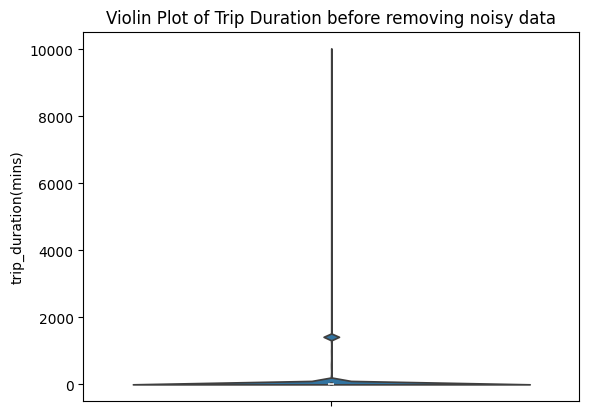

In [38]:
#Before removing the violated data (trip duration for a ride)

sns.violinplot(y="trip_duration(mins)", data=nyc_data_eng)
plt.title('Violin Plot of Trip Duration before removing noisy data')
plt.show()

The presence of a long tail indicates that although extended trips are feasible, they are somewhat infrequent.

As the time increases, the width of the violin gradually decreases, indicating a rapid decline in the frequency of longer trips.


In [39]:
nyc_data_eng = nyc_data_eng [(nyc_data_eng['trip_duration(mins)']>0) & (nyc_data_eng['trip_duration(mins)']<720)]

In [40]:
nyc_data_eng.shape

(8381450, 21)

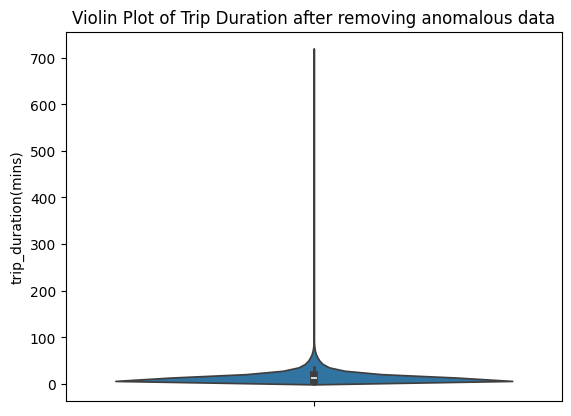

In [41]:
#violinplot after removal of outliers
sns.violinplot(y="trip_duration(mins)", data=nyc_data_eng)
plt.title('Violin Plot of Trip Duration after removing anomalous data')
plt.show()

The violin plot illustrates the arrangement of trip lengths subsequent to the removal of anomalous data. It offers a more unique perspective on average travel durations, unaffected by the misleading influence of exceptional data points.

The presence of a lengthy and skinny tail suggests the occurrence of rare extended journeys, but with reduced frequency. - The majority of the plot exhibits a relatively narrow trajectory, showing a diminished level of variability in the data, characterised by a reduced number of extreme values.

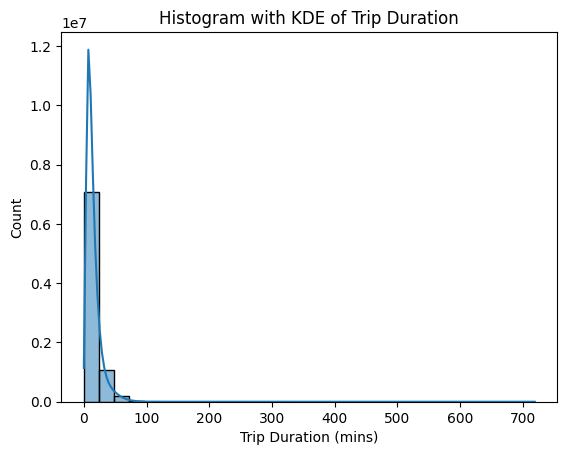

In [42]:
sns.histplot(nyc_data_eng['trip_duration(mins)'], kde=True, bins=30)

# Labeling the axes and title
plt.xlabel('Trip Duration (mins)')
plt.ylabel('Count')
plt.title('Histogram with KDE of Trip Duration')

# Display the plot
plt.show()

Most trips have short durations, with a significant rise at the shorter end of the duration range. The observed peak indicates that cab rides are generally of short duration, which could indicate urban commutes or short travel distances within a city.

The counts exhibit a significant decline as the duration of the trip grows, an occurrence that is typical in transit where brief trips are more common.

The presence of low bars extending towards the right of the plot indicates the lack of long-duration journeys.



**Speed**

**Checking percentile variations in speed(mph) feature**

In [43]:
for i in range(0,100,10):
    var =nyc_data_eng["avg_speed(mph)"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))


#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =nyc_data_eng["avg_speed(mph)"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
#print("100 percentile value is ",var[-1])

#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =nyc_data_eng["avg_speed(mph)"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 5.81
20 percentile value is 7.1
30 percentile value is 8.09
40 percentile value is 9.02
50 percentile value is 10.0
60 percentile value is 11.16
70 percentile value is 12.69
80 percentile value is 15.19
90 percentile value is 20.67
90 percentile value is 20.67
91 percentile value is 21.55
92 percentile value is 22.53
93 percentile value is 23.62
94 percentile value is 24.85
95 percentile value is 26.28
96 percentile value is 28.02
97 percentile value is 30.13
98 percentile value is 32.88
99 percentile value is 36.89
99.0 percentile value is 36.89
99.1 percentile value is 37.44
99.2 percentile value is 38.06
99.3 percentile value is 38.76
99.4 percentile value is 39.55
99.5 percentile value is 40.47
99.6 percentile value is 41.55
99.7 percentile value is 42.9
99.8 percentile value is 44.88
99.9 percentile value is 48.66
100 percentile value is  518811.43


Taxi speeds commence at 0 mph, potentially indicating the presence of idle taxis or inaccuracies.

The median speed of the taxis is 10.25 mph, indicating that half of them ride at or below this pace, which accurately represents the driving circumstances in metropolitan areas.

At higher percentiles, there is a gradual increase in speeds, with the 90th percentile recorded at 21.59 mph. This observation implies that faster travel may be attributed to reduced traffic congestion or decreased use of highways.

The significant increase in speeds at the highest percentiles, reaching an unbelievable 518,811.43 mph at the 100th percentile, clearly indicates the presence of data inaccuracies.


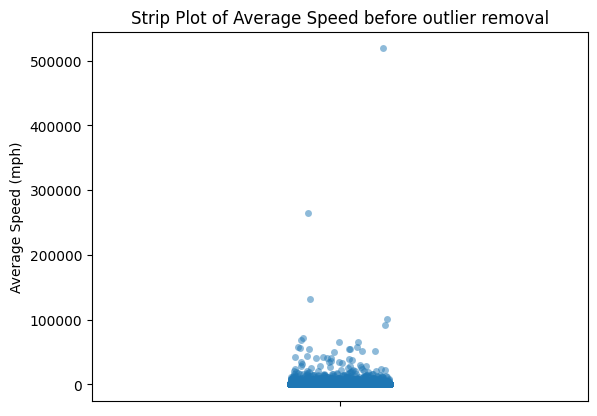

In [44]:

# Strip plot of avg_speed(mph)
sns.stripplot(y='avg_speed(mph)', data=nyc_data_eng, jitter=True, alpha=0.5)


plt.ylabel('Average Speed (mph)')
plt.title('Strip Plot of Average Speed before outlier removal')


plt.show()


- The majority of data points are concentrated towards the lower range, suggesting that the average speed for taxis is rather low, which is likely a reflection of the typical driving circumstances in cities.

- Several data points are spread out above the primary cluster, indicating possible variances in speed that could be attributed to longer trips on quicker routes or errors in data collecting.

- The value at the highest point is an anomaly, significantly different from the rest and suggests the presence of an outlier or an error in the data.


In [45]:
#avg.speed of cabs in New-York
sum(nyc_data_eng["avg_speed(mph)"]) / float(len(nyc_data_eng["avg_speed(mph)"]))

12.802471359966328

In [46]:
nyc_data_eng[nyc_data_eng["avg_speed(mph)"] > 60].shape

(4144, 21)

In [47]:
#Now cleaning the rows with speed greater than 60

nyc_data_eng=nyc_data_eng[(nyc_data_eng['avg_speed(mph)']>0) & (nyc_data_eng['avg_speed(mph)']<60)]

Cleaning the dataset with speed greater than 60mph on NY city roads.

In [48]:
nyc_data_eng.shape

(8282969, 21)

In [49]:
nyc_data_eng.head()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration(mins),avg_speed(mph)
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,1.0,0.5,0.00,0.0,1.0,14.30,2.5,0.0,8.43,6.90
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.0,0.5,4.00,0.0,1.0,16.90,2.5,0.0,6.32,10.44
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0,10.83,7.92
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,...,1.0,0.5,10.00,0.0,1.0,27.80,2.5,0.0,12.30,8.98
6,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,...,1.0,0.5,3.42,0.0,1.0,20.52,2.5,0.0,10.45,9.53


### **Extracting Weather Data using Weather API from Visualcrossing**

The accuracy and utility of a NYC taxi demand prediction are greatly increased when weather data is added. The demand for taxis and the supply of drivers are both impacted by the weather. For example, when it's raining or snowing, more individuals choose to use cabs because they don't want to walk or ride their bikes. In the same way, high temperatures may encourage more people to use taxis. The effects of the weather might change during the day and in different parts of the city, which can affect demand trends. The model can capture these subtleties and provide a more comprehensive picture of how weather impacts taxi demand by including weather data, such as temperature, precipitation, humidity, and wind speed.

In [ ]:
import requests
from datetime import datetime
from io import StringIO
import pandas as pd



def get_weather_data(api_key, location, start_date, end_date,content):
    base_url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"

    # Formatting the request URL
    request_url = f"{base_url}/{location}/{start_date}/{end_date}?unitGroup=us&include={content}&key={api_key}&contentType=csv"

    response = requests.get(request_url)
    print(response)
    if response.status_code == 200:
        data = StringIO(response.text)
        weather_df = pd.read_csv(data)
        return weather_df
    else:
        print("Failed to fetch data")
        return None

# Configuration
api_key = 'NG4YBQ7MRFZLMHM6G8N3KSF8H'
location = "New York, NY"
start_date = '2023-02-01'
end_date = '2023-02-28'
content = 'hours'

# # Fetching the weather data from api
#weather_events = get_weather_data(api_key, location, start_date, end_date, content)



In [ ]:
#weather_events.head()


In [ ]:
#weather_events.to_csv('weather_data_march_hourly.csv',index=False)

In [50]:
weather_df_jan = pd.read_csv('weather_data_jan_hourly (1).csv')

weather_df_feb = pd.read_csv('weather_data_feb_hourly (1).csv')

weather_df_mar = pd.read_csv('weather_data_march_hourly (1).csv')

weather_df = pd.concat([weather_df_jan,weather_df_feb,weather_df_mar])

weather_df.shape

(2159, 24)

In [51]:
weather_df.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"New York, NY, United States",2023-01-01T00:00:00,54.0,54.0,51.8,92.43,0.009,100,rain,0.0,...,1007.1,100.0,7.7,227,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
1,"New York, NY, United States",2023-01-01T01:00:00,53.1,53.1,50.9,92.14,0.001,100,rain,0.0,...,1007.2,100.0,7.2,228,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
2,"New York, NY, United States",2023-01-01T02:00:00,53.3,53.3,50.0,88.43,0.004,100,rain,0.0,...,1006.8,43.6,7.7,227,0.8,0,10,"Rain, Partially cloudy",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
3,"New York, NY, United States",2023-01-01T03:00:00,52.6,52.6,49.7,89.82,0.000,0,NaN,0.0,...,1007.8,13.4,9.0,224,0.8,0,10,Clear,clear-night,"72505394728,KLGA,D2180,KNYC,72503014732"
4,"New York, NY, United States",2023-01-01T04:00:00,53.3,53.3,48.6,83.95,0.000,0,NaN,0.0,...,1008.1,7.2,9.9,222,0.8,0,10,Clear,clear-night,"72505394728,KLGA,D2180,KNYC,72503014732"


In [52]:
weather_df.isnull().sum()

name                   0
datetime               0
temp                   0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
preciptype          1805
snow                   0
snowdepth              0
windgust               0
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk             0
conditions             0
icon                   0
stations               0
dtype: int64

In the weather dataset, we have found that In the ‘preciptype’ columns, there are null values since we don’t consider the column for modelling, we have dropped that column and there are unnecessary symbols in the datetime column. As a part of the data cleaning process, these unnecessary symbols are removed.

In [53]:
weather_df.drop(columns = ['preciptype'],inplace=True)

In [54]:
weather_df.dtypes

name                 object
datetime             object
temp                float64
feelslike           float64
dew                 float64
humidity            float64
precip              float64
precipprob            int64
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddir               int64
sealevelpressure    float64
cloudcover          float64
visibility          float64
solarradiation        int64
solarenergy         float64
uvindex               int64
severerisk            int64
conditions           object
icon                 object
stations             object
dtype: object

In [55]:
weather_df.describe()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk
count,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.000000,2159.0
mean,42.988837,39.275035,28.474247,59.207638,0.002890,10.792033,0.002209,0.036836,16.678648,7.170218,213.452987,1016.016906,50.020658,9.331820,144.893932,0.521630,1.037054,10.0
std,7.821850,10.184765,10.513108,19.055924,0.016161,31.035165,0.056185,0.277801,8.520598,3.981921,111.146150,7.880842,45.500193,1.655673,186.480523,0.671807,1.916592,0.0
min,6.400000,-10.200000,-11.400000,18.130000,0.000000,0.000000,0.000000,0.000000,2.200000,0.000000,0.000000,991.300000,0.000000,0.600000,0.000000,0.000000,0.000000,10.0
25%,38.000000,32.900000,21.600000,45.300000,0.000000,0.000000,0.000000,0.000000,9.200000,4.700000,100.000000,1010.450000,1.500000,9.900000,0.000000,0.000000,0.000000,10.0
50%,42.400000,38.700000,27.900000,56.900000,0.000000,0.000000,0.000000,0.000000,16.100000,6.700000,258.000000,1016.500000,32.000000,9.900000,59.000000,0.200000,0.000000,10.0
75%,47.900000,45.300000,35.700000,73.590000,0.000000,0.000000,0.000000,0.000000,21.550000,9.200000,300.000000,1021.900000,100.000000,9.900000,220.000000,0.800000,1.000000,10.0
max,65.700000,65.700000,56.400000,99.720000,0.268000,100.000000,2.400000,3.230000,59.700000,28.300000,360.000000,1039.000000,100.000000,9.900000,894.000000,3.200000,9.000000,10.0


In [56]:
weather_df['datetime'] = pd.to_datetime(pd.to_datetime(weather_df['datetime']).dt.strftime("%Y-%m-%d %H:%M:%S"))


In [57]:
weather_df.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"New York, NY, United States",2023-01-01 00:00:00,54.0,54.0,51.8,92.43,0.009,100,0.0,0.0,...,1007.1,100.0,7.7,227,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
1,"New York, NY, United States",2023-01-01 01:00:00,53.1,53.1,50.9,92.14,0.001,100,0.0,0.0,...,1007.2,100.0,7.2,228,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
2,"New York, NY, United States",2023-01-01 02:00:00,53.3,53.3,50.0,88.43,0.004,100,0.0,0.0,...,1006.8,43.6,7.7,227,0.8,0,10,"Rain, Partially cloudy",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
3,"New York, NY, United States",2023-01-01 03:00:00,52.6,52.6,49.7,89.82,0.000,0,0.0,0.0,...,1007.8,13.4,9.0,224,0.8,0,10,Clear,clear-night,"72505394728,KLGA,D2180,KNYC,72503014732"
4,"New York, NY, United States",2023-01-01 04:00:00,53.3,53.3,48.6,83.95,0.000,0,0.0,0.0,...,1008.1,7.2,9.9,222,0.8,0,10,Clear,clear-night,"72505394728,KLGA,D2180,KNYC,72503014732"


In [58]:
weather_df.dtypes

name                        object
datetime            datetime64[ns]
temp                       float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipprob                   int64
snow                       float64
snowdepth                  float64
windgust                   float64
windspeed                  float64
winddir                      int64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation               int64
solarenergy                float64
uvindex                      int64
severerisk                   int64
conditions                  object
icon                        object
stations                    object
dtype: object

In [59]:
nyc_data_eng['pickup_hour'] = nyc_data_eng['pickup_datetime'].dt.floor('H')

### **Merging the weather data and the NYC taxi Dataset:**

In [60]:
nyc_taxi_merged = pd.merge(nyc_data_eng,weather_df[['datetime','temp','precip','windspeed','visibility']],left_on='pickup_hour',right_on='datetime',how='left')

In [61]:
nyc_taxi_merged.isnull().sum()

vendorid                 0
pickup_datetime          0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
ratecodeid               0
store_and_fwd_flag       0
pickup_location_id       0
dolocationid             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
trip_duration(mins)      0
avg_speed(mph)           0
pickup_hour              0
datetime                 0
temp                     0
precip                   0
windspeed                0
visibility               0
dtype: int64

In [62]:
nyc_taxi_merged.drop(columns=['datetime'],inplace=True)

In the second phase of our analysis, we added the previously gathered meteorological data to the New York City taxi data. This improvement was made possible by the incorporation of weather- and time-related data, which allowed for a more in-depth investigation of the elements affecting taxi demand.

Our analysis is based on this expanded dataset, which allows us to examine the effects of meteorological variables on New York City taxi usage patterns. Through the analysis of this combined dataset, we hope to gain a better understanding of how temporal and climatic elements affect taxi demand patterns. This will help us build prediction models for urban transportation planning that are more precise. Since we already have the pickup time and drop-off time is available in our dataset and the datatime column is no longer needed we have dropped that column.


In [63]:
nyc_taxi_merged.head()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,...,total_amount,congestion_surcharge,airport_fee,trip_duration(mins),avg_speed(mph),pickup_hour,temp,precip,windspeed,visibility
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,14.30,2.5,0.0,8.43,6.90,2023-01-01,54.0,0.009,1.9,7.7
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,16.90,2.5,0.0,6.32,10.44,2023-01-01,54.0,0.009,1.9,7.7
2,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,19.68,2.5,0.0,10.83,7.92,2023-01-01,54.0,0.009,1.9,7.7
3,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,...,27.80,2.5,0.0,12.30,8.98,2023-01-01,54.0,0.009,1.9,7.7
4,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,...,20.52,2.5,0.0,10.45,9.53,2023-01-01,54.0,0.009,1.9,7.7


In [64]:
nyc_taxi_merged.shape

(8282969, 26)

In [65]:

nyc_taxi_merged['Hour'] = nyc_taxi_merged['pickup_datetime'].dt.hour
nyc_taxi_merged['dayofweek'] = nyc_taxi_merged['pickup_datetime'].dt.dayofweek
nyc_taxi_merged['Month'] = nyc_taxi_merged['pickup_datetime'].dt.month

In [66]:
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = [16, 10]

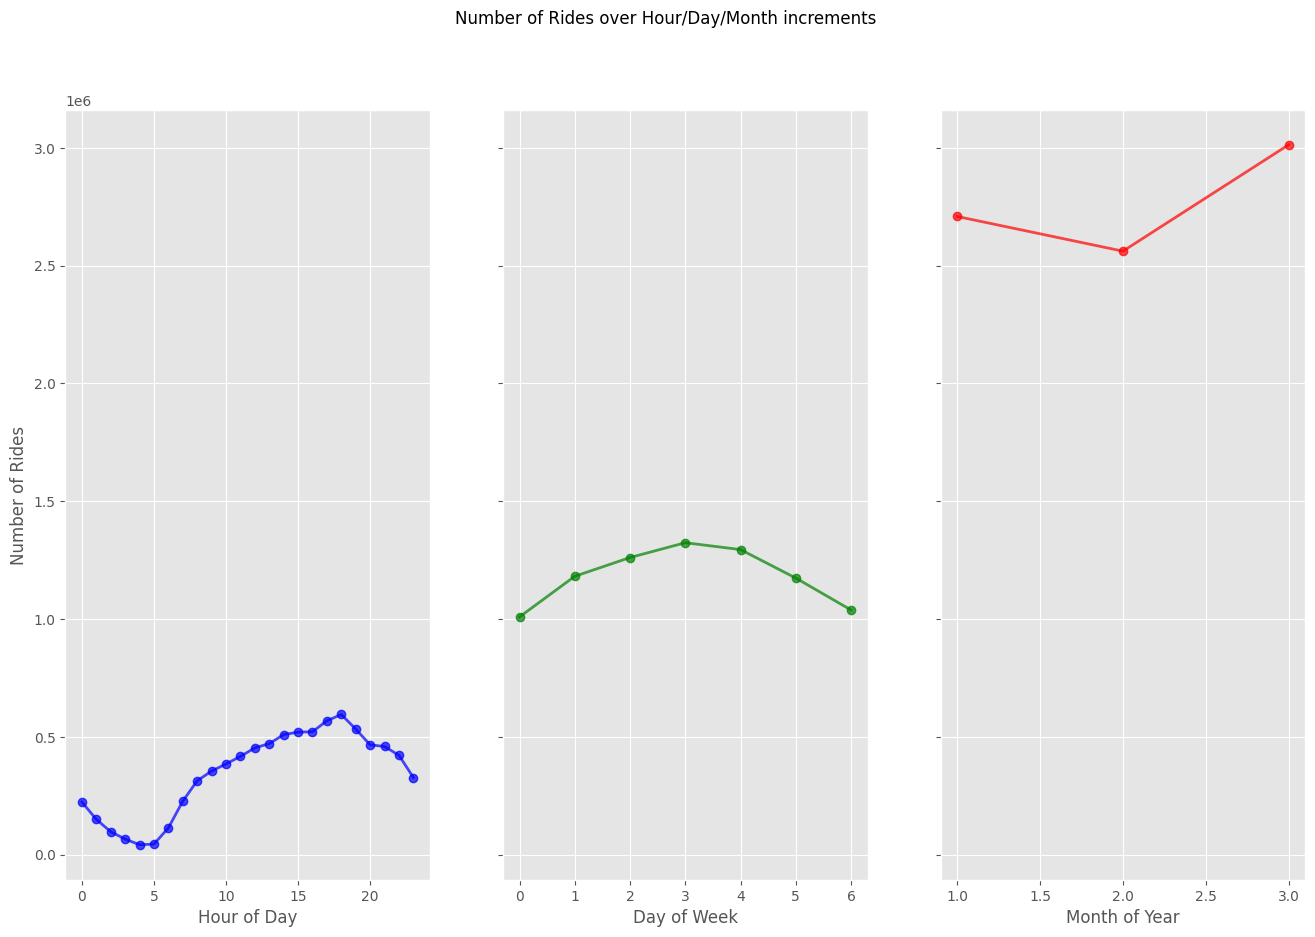

In [67]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(nyc_taxi_merged.groupby('Hour').count()['pickup_datetime'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(nyc_taxi_merged.groupby('dayofweek').count()['pickup_datetime'], 'go-', lw=2, alpha=0.7)
ax[2].plot(nyc_taxi_merged.groupby('Month').count()['pickup_datetime'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Number of Rides')
fig.suptitle('Number of Rides over Hour/Day/Month increments')
plt.show()

The distribution of taxi rides in New York City is depicted in the accompanying graphic along three temporal dimensions: hour of the day, day of the week, and month of the year.

A distinct pattern that indicates that there are substantial variations in taxi demand throughout the day can be seen in the 'Hour of Day' subplot. The number of rides has increased noticeably; it starts to rise in the early morning, peaks in the evening and then falls off in the late hours of the night. This may suggest that commutes made in the evening rush hour are when people use taxi services the most.


Within the 'Day of Week' subplot, taxi rides seem to be consistent every day, but with a small fluctuation. There isn't a noticeable uptick or decrease in demand on any one day, indicating that there are only slight variations in the demand for taxis throughout the week.

The 'Month of Year' subplot, which is restricted to data from just two months, concludes by displaying a marginal decline in the total number of rides between January and February. Seasonal variables may be to blame for this declining tendency, but a more thorough analysis would need to include data from succeeding months.



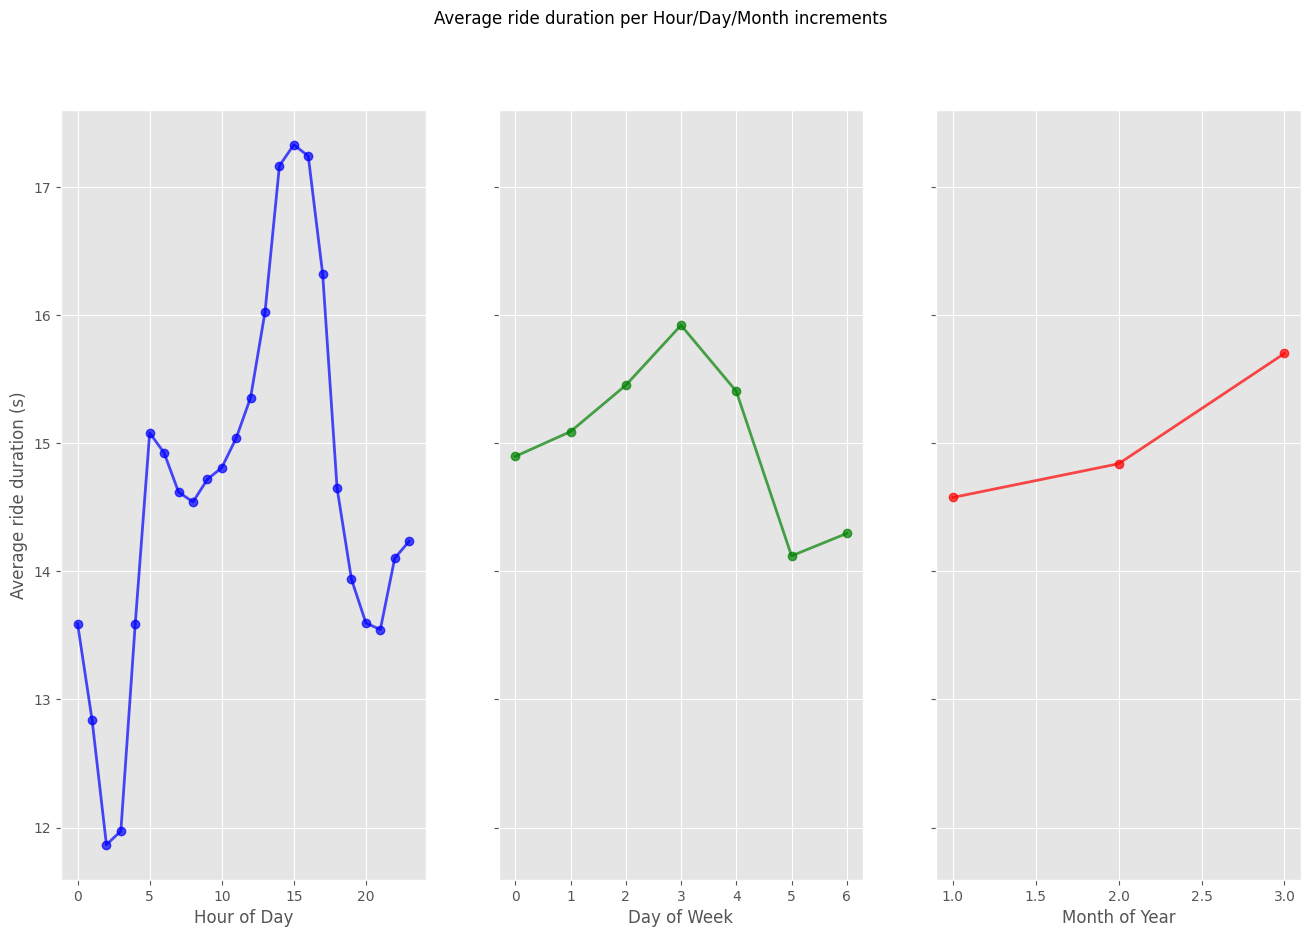

In [68]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(nyc_taxi_merged.groupby('Hour')['trip_duration(mins)'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(nyc_taxi_merged.groupby('dayofweek')['trip_duration(mins)'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(nyc_taxi_merged.groupby('Month')['trip_duration(mins)'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average ride duration (s)')
fig.suptitle('Average ride duration per Hour/Day/Month increments')
plt.show()

The plot representation shows clear trends about the average length of a taxi ride in New York City throughout various periods.

Average journey times peak substantially during specific hours, as seen in the 'Hour of Day' graphic, which shows significant variability. The significant peak indicates that passengers have much longer rides at some times, possibly during rush hours. This is probably because of traffic congestion or the fact that passengers are traveling longer distances during these times.

There is a discernible pattern in the 'Day of Week' graph where the average journey duration rises in the middle of the week before leveling out. This could mean that activities related to work or midweek activities that necessitate longer taxi rides are concentrated there, with a decline towards the weekend.

The 'Month of Year' plot indicates a marginal rise in the average ride duration from January to February, despite only having two data points. Even though this increased tendency indicates that taxi rides would gradually lengthen during the year, at least in these two months, more information from the full year would be required to make firm judgments.

<Axes: xlabel='Hour', ylabel='trip_duration(mins)'>

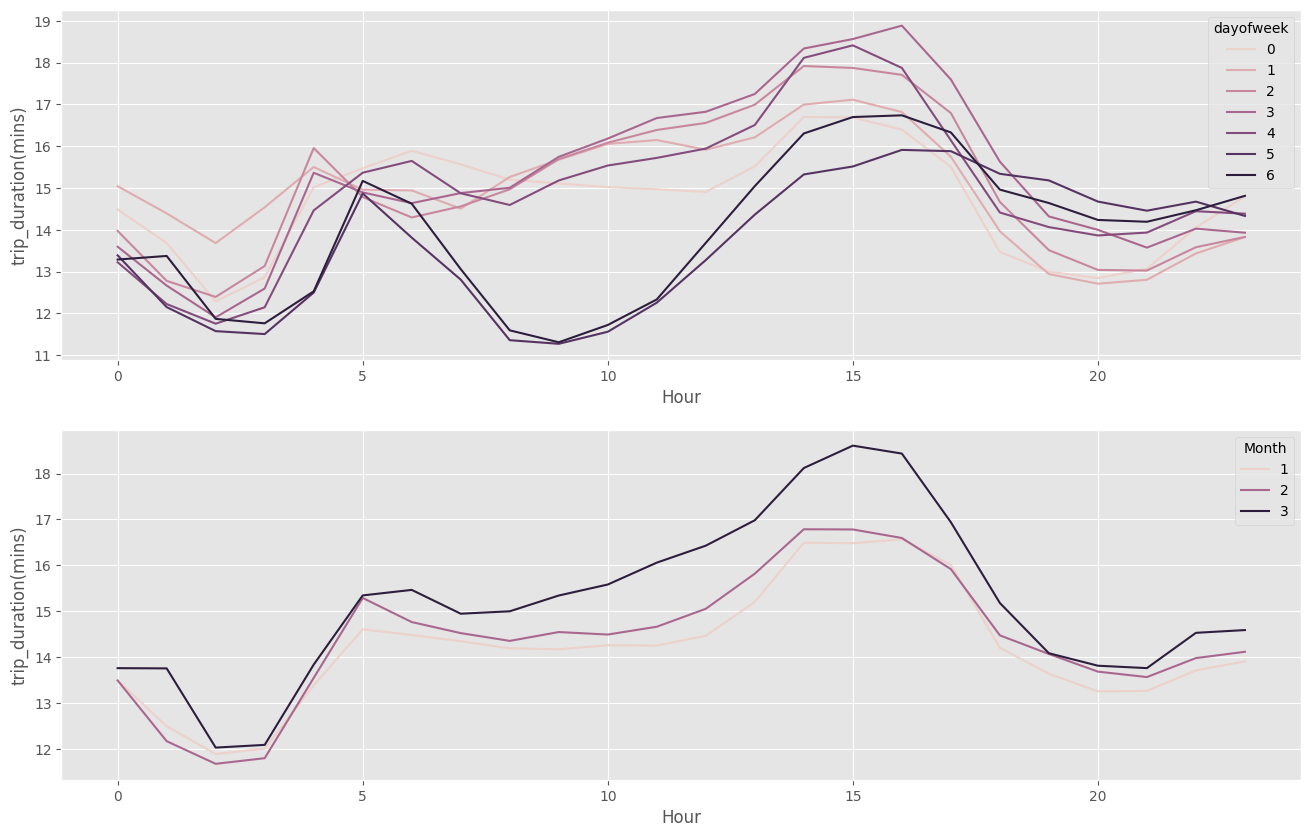

In [69]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#weekday rides plotting

weekday_rides= pd.DataFrame(nyc_taxi_merged.groupby(['dayofweek', 'Hour'])['trip_duration(mins)'].mean())

weekday_rides.reset_index(inplace =True)
sns.lineplot(data=weekday_rides, x  = 'Hour', y= 'trip_duration(mins)', hue = 'dayofweek', ax=ax1)

#monthly rides plotting

monthly_rides= pd.DataFrame(nyc_taxi_merged.groupby(['Month', 'Hour'])['trip_duration(mins)'].mean())

monthly_rides.reset_index(inplace =True)
sns.lineplot(data=monthly_rides,x = 'Hour',  y= 'trip_duration(mins)', hue = 'Month', ax=ax2)



The above visualizations show how the average length of a taxi ride varies during the day, broken out by day of the week and month.

The average travel duration is broken down by day of the week in the first plot, and all days show a distinct diurnal trend. Travel times tend to be shorter in the early morning and longer in the late evening, around rush hour, indicating that longer trips are made during periods of more traffic.

Additionally, there is a hint of extended durations around midday, which could be attributed to a variety of things like midday errands or tourist activities. There are also noticeable differences among the days of the week; for example, some days have significantly longer travelled on average, which may be an indication of the particular demand patterns connected to those days.

The average trip duration over a two-month period is shown in the second figure by hour. The journey duration increases during the morning and into the afternoon, peaks in the evening, and then decreases into late night in both January and February. The pattern's persistence over the course of two months points to a steady temporal influence on trip duration, most likely because of off-peak quiet times and rush hour traffic. The plot does, however, indicate a tiny overall rise in the average travel duration from January to February at specific hours, which could be explained by variations in the seasonal weather that impact traffic patterns.

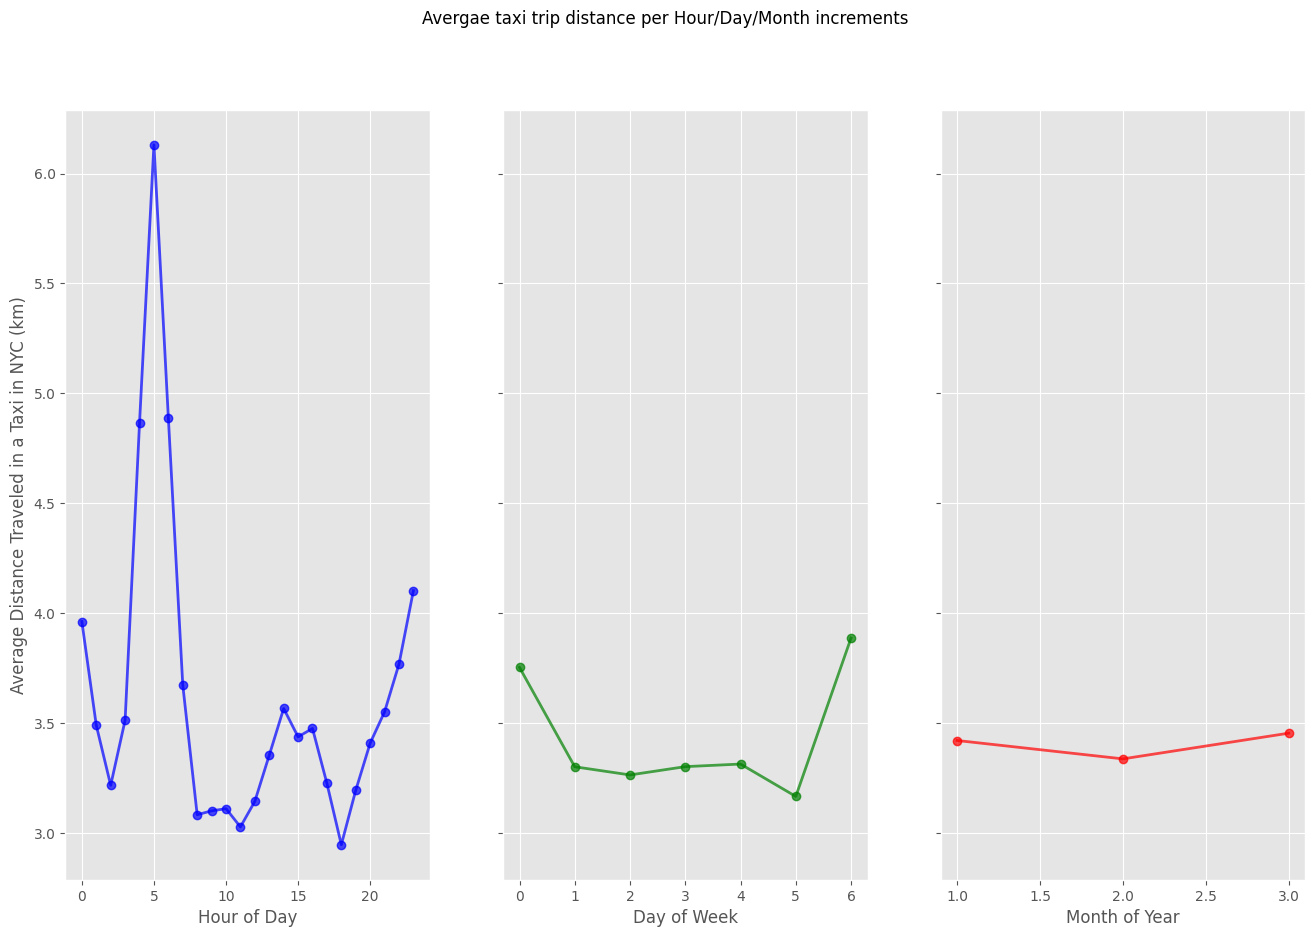

In [70]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(nyc_taxi_merged.groupby('Hour')['trip_distance'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(nyc_taxi_merged.groupby('dayofweek')['trip_distance'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(nyc_taxi_merged.groupby('Month')['trip_distance'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Distance Traveled in a Taxi in NYC (km)')
fig.suptitle('Avergae taxi trip distance per Hour/Day/Month increments')
plt.show()

The average cab trip distance in New York City during various periods is plotted in the above plots.

The 'Hour of Day' plot is highly variable, with the highest average travel distances being in the wee hours of the morning. Due to a higher percentage of airport runs or less traffic restrictions, this peak indicates that trips taken during these hours are lengthier. After that, the distances vary for the remainder of the day and drop during the morning rush hour, probably because of fewer commuter travels.


The average distances for most days are rather steady, with a considerable increase on the last day of the regular workweek, as seen by the 'Day of Week' plot. This may indicate a pattern of lengthier travels before the weekend, either for vacation or for business.

The 'Month of Year' plot, which is restricted to two points, illustrates a marginal decline in the average distance between January and February. This pattern could be a sign of seasonal elements influencing travel patterns, such bad weather making people want shorter journeys.



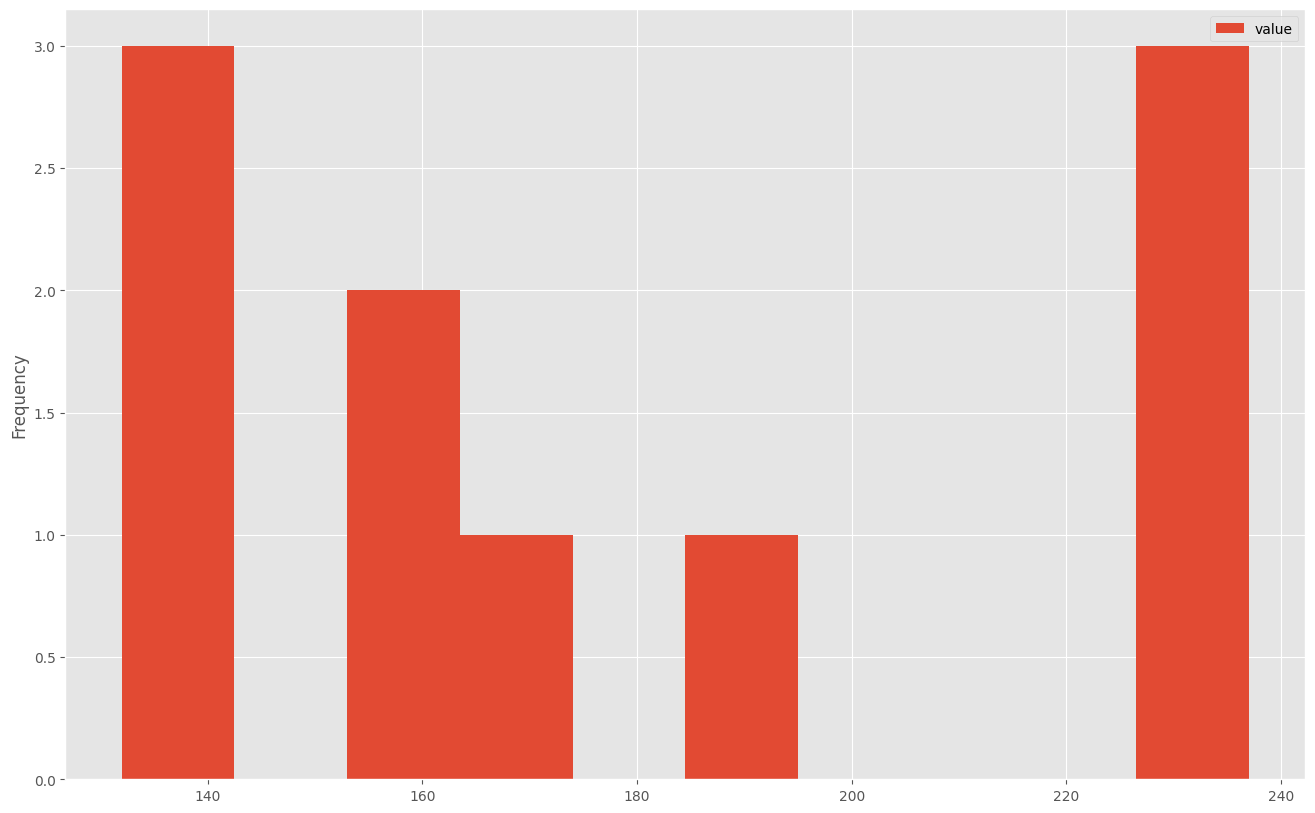

In [71]:

plot_df = (
    nyc_taxi_merged['pickup_location_id'].value_counts()
        .head(10)
        .rename_axis('value')
        .reset_index(name='counts')
)
ax = plot_df.plot(x='counts', kind='hist')

The pickup count categories with very high frequency, which indicates that at least one location has a significantly higher number of pickups than the others, and moderate frequency, which indicates a lower but still significant number of pickups, are the two prominent categories that stand out in the histogram. In contrast to the remaining sites, which have relatively high pickup activity, the distribution points to a small number of places having extremely high pickup counts.

With some areas serving as pickup hotspots, this graphic illustrates the unequal distribution of taxi demand among the best places. To optimize efficiency, taxi operators should consider strategically positioning their vehicles and concentrating on certain locations with high demand. Because of the strong demand for transportation, this suggests regions for urban planners that would require greater infrastructure support.

## **Data Preparation**

In [72]:
nyc_taxi_merged.columns

Index(['vendorid', 'pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'ratecodeid', 'store_and_fwd_flag',
       'pickup_location_id', 'dolocationid', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'trip_duration(mins)', 'avg_speed(mph)', 'pickup_hour',
       'temp', 'precip', 'windspeed', 'visibility', 'Hour', 'dayofweek',
       'Month'],
      dtype='object')

In [73]:



# Grouping by 'pickup_hour' and 'pickup_location_id', then aggregating
nyc_agg_rides = nyc_taxi_merged.groupby(['pickup_hour', 'pickup_location_id']).agg({
    'passenger_count': 'sum',  # Total passengers per hour per location
    'trip_distance': 'sum',  # Total distance per hour per location
    'total_amount': 'sum',  # Total amount per hour per location
    'trip_duration(mins)': 'mean',  # Average trip duration
    'avg_speed(mph)': 'mean',  # Average speed
    'temp': 'mean',  # Average temperature
    'precip': 'mean',  # Average precipitation
    'windspeed': 'mean',  # Average wind speed
    'visibility': 'mean',  # Average visibility
    'dolocationid': 'count'  # Count of rides
}).reset_index()

# Rename aggregated columns
nyc_agg_rides.rename(columns={
    'passenger_count': 'total_passenger_count',
    'trip_distance': 'total_trip_distance',
    'total_amount': 'total_amount',
    'trip_duration(mins)': 'avg_trip_duration',
    'avg_speed(mph)': 'avg_speed',
    'temp': 'avg_temp',
    'precip': 'avg_precip',
    'windspeed': 'avg_windspeed',
    'visibility': 'avg_visibility',
    'dolocationid': 'total_rides'  # Renaming the count column to 'total_rides'
}, inplace=True)




To gain insights on taxi usage by pickup location and hour, the `nyc_taxi_merged` DataFrame was aggregated for study. Measures of passenger volume, service reach, and revenue were computed using metrics such `total_passenger_count`, `total_trip_distance`, and `total_amount`. To evaluate their effects on taxi operations, mean values for trip time, taxi speed, and different weather conditions were also calculated. A gauge of service demand was given by the number of `total_rides`. Understanding taxi service trends and guiding effective urban transportation management requires this data aggregation.

This aggregation is required to capture and comprehend the complex dynamics of taxi service utilization in both spatial and temporal dimensions. The goal of the study is to find trends and connections between service use and variables like location, weather, and time of day by examining these aggregated metrics. Strategic decisions on where and when to add more vehicles, how the weather affects traffic patterns, and other matters related to taxi fleet management and municipal planning can be made with the help of this comprehensive research.


In [74]:
nyc_agg_rides.head()

,pickup_hour,pickup_location_id,total_passenger_count,total_trip_distance,total_amount,avg_trip_duration,avg_speed,avg_temp,avg_precip,avg_windspeed,avg_visibility,total_rides
0,2023-01-01,4,21.0,45.80,381.90,16.100714,12.188571,54.0,0.009,1.9,7.7,14
1,2023-01-01,7,3.0,13.80,103.37,18.263333,15.066667,54.0,0.009,1.9,7.7,3
2,2023-01-01,12,1.0,1.90,20.52,10.550000,10.810000,54.0,0.009,1.9,7.7,1
3,2023-01-01,13,18.0,42.15,336.59,12.600000,14.213077,54.0,0.009,1.9,7.7,13
4,2023-01-01,24,18.0,37.51,290.34,11.729231,13.826154,54.0,0.009,1.9,7.7,13


In [75]:
nyc_agg_rides.shape

(189478, 12)

In [76]:
##Add missing slots

from tqdm import tqdm

def add_missing_slots(nyc_agg_rides: pd.DataFrame) -> pd.DataFrame:

    location_ids = nyc_agg_rides['pickup_location_id'].unique()
    full_range = pd.date_range(
        nyc_agg_rides['pickup_hour'].min(), nyc_agg_rides['pickup_hour'].max(), freq='H')
    output = pd.DataFrame()
    for location_id in tqdm(location_ids):

        # keep only rides for this 'location_id'
        nyc_agg_rides_i = nyc_agg_rides[nyc_agg_rides['pickup_location_id'] == location_id]

        nyc_agg_rides_i.set_index('pickup_hour', inplace=True)
        nyc_agg_rides_i.index = pd.DatetimeIndex(nyc_agg_rides_i.index)
        nyc_agg_rides_i = nyc_agg_rides_i.reindex(full_range, fill_value=0)


        # add back `location_id` columns
        nyc_agg_rides_i['pickup_location_id'] = location_id

        output = pd.concat([output, nyc_agg_rides_i])

    # move the purchase_day from the index to a dataframe column
    output = output.reset_index().rename(columns={'index': 'pickup_hour'})

    return output

In [77]:
nyc_agg_rides_all_slots = add_missing_slots(nyc_agg_rides)

100%|██████████| 260/260 [00:04<00:00, 64.63it/s]


In [78]:
nyc_agg_rides_all_slots.shape

(561600, 12)

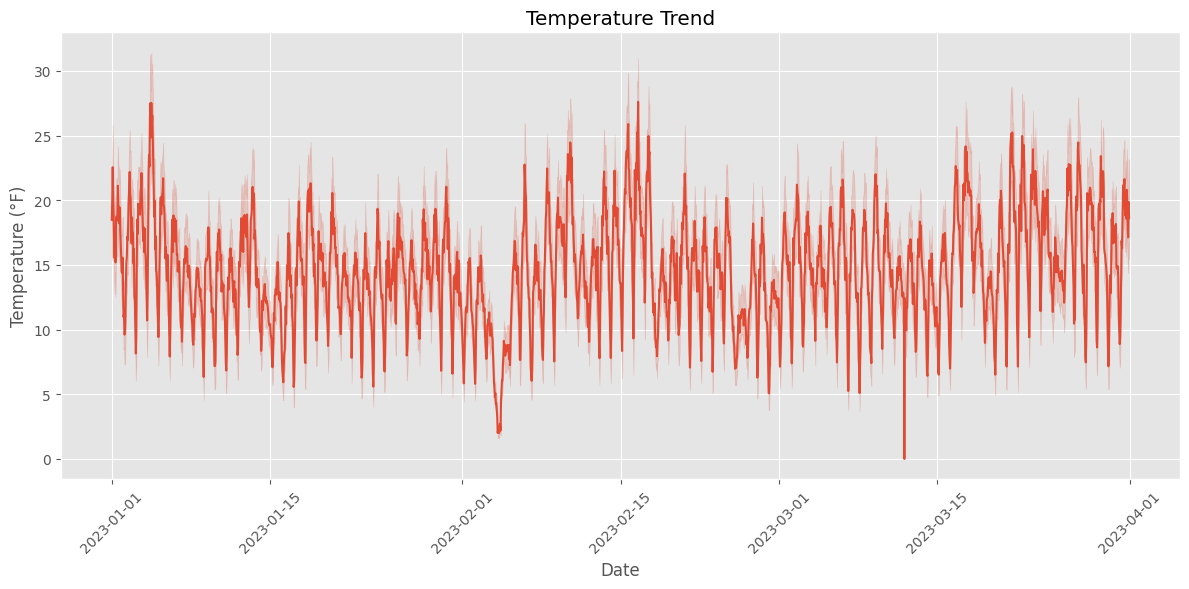

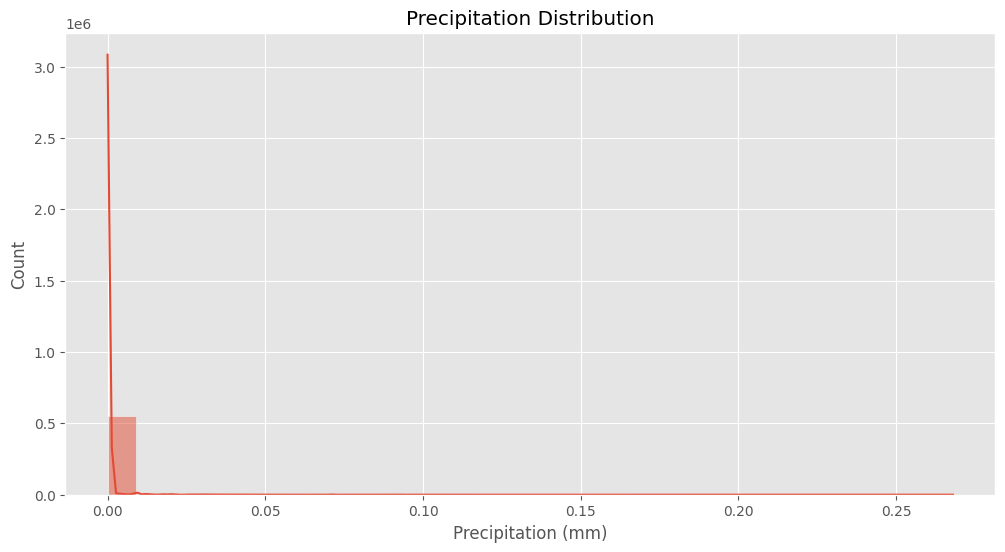

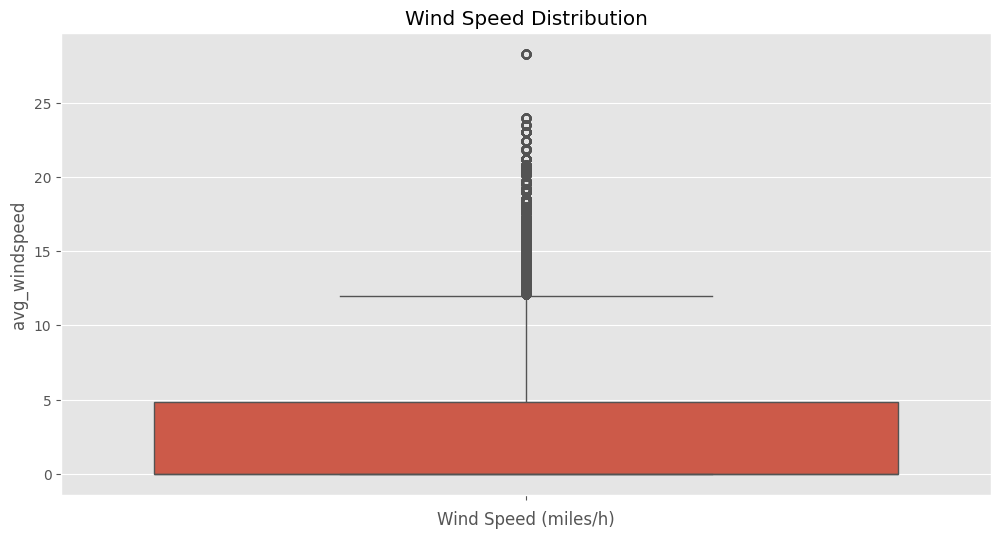

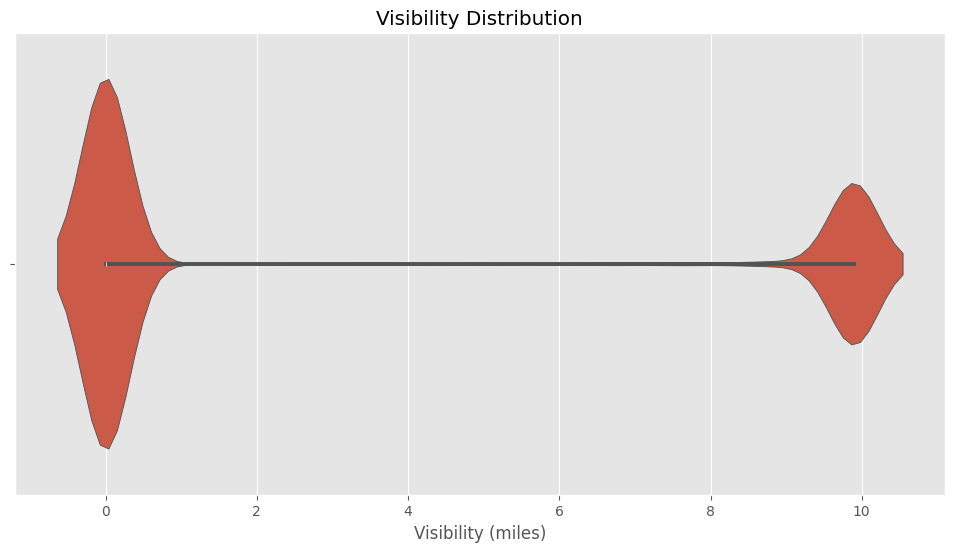

In [79]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='pickup_hour', y='avg_temp', data=nyc_agg_rides_all_slots)  # Adjust x and y according to your dataset
plt.title('Temperature Trend')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.xticks(rotation=45)
plt.tight_layout()

# Precipitation - Histogram
plt.figure(figsize=(12, 6))
sns.histplot(nyc_agg_rides_all_slots['avg_precip'], bins=30, kde=True)
plt.title('Precipitation Distribution')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Count')

# Wind Speed - Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(y=nyc_agg_rides_all_slots['avg_windspeed'])
plt.title('Wind Speed Distribution')
plt.xlabel('Wind Speed (miles/h)')
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(x=nyc_agg_rides_all_slots['avg_visibility'])
plt.title('Visibility Distribution')
plt.xlabel('Visibility (miles)')
plt.show()



**Temperature Trend**

The plot displays the daily temperature fluctuations spanning from early January to late February 2023. The temperatures vary between around 5°F and 30°F, without any evident long-term pattern suggesting a seasonal change. This indicates a consistent climate pattern without any shifts from cold to warm seasons or vice versa during this period.

**Precipitation Distribution**

The histogram showcases the distribution of precipitation measurements, with a majority of the data points clustered around zero or close to it. This suggests that there were numerous days with minimal or no rainfall. The distribution exhibits a pronounced right-skew, indicating that the occurrence of higher precipitation amounts is relatively infrequent in this dataset.

**Wind Speed Distribution**

The boxplot provides a visual representation of the wind speed distribution. The wind speed tends to concentrate in the lower range, with a median of approximately 10 miles per hour. The presence of outliers suggests occasional instances of high wind speeds that surpass the usual range. Based on the data, it appears that wind conditions are typically calm to moderate, with occasional days of stronger gusts.

**Visibility Distribution**

The visibility distribution is depicted in the violin plot, which shows two prominent peaks. This indicates the presence of two prevalent conditions: one characterized by low visibility and another characterized by high visibility, close to the maximum value on the scale. This distribution suggests that visibility conditions vary greatly, with instances of both poor and excellent visibility, but fewer instances of moderate visibility. The narrowest sections of the violin, located between these two peaks, indicate a decrease in the number of days with intermediate visibility levels.


In [80]:
def plot_rides(
    rides,
    locations
    ):
    """
    Plot time-series data
    """
    rides_to_plot = rides[rides.pickup_location_id.isin(locations)] if locations else rides

    fig = px.line(
        rides_to_plot,
        x="pickup_hour",
        y="total_rides",
        color='pickup_location_id',
        template='none',
    )

    fig.show()

In [81]:
plot_rides(nyc_agg_rides_all_slots, locations=[43])

The time series of all taxi rides for location ID 43 over two months is shown in the generated figure. Strong cyclical patterns in the graphic show variations in the number of taxi rides over time. Peak ride counts probably correlate with times of strong demand, which could be related to weekends, special events, or rush hours. Valleys, on the other hand, indicate times of decreased demand.

The consistency of these patterns may be an indication of regular commuting behavior, or it may point to systematic variations in ride usage according to the day of the week or time of day. Higher peaks might, for example, be associated with the mornings or evenings of workdays, whereas lower activity troughs might be associated with late nights or non-peak days.


In [ ]:
# nyc_agg_rides_all_slots.to_csv('nyc_agg_rides_all_slots_Jan_Feb.csv',index=False)

In [82]:
def get_cutoff_indices(
    data: pd.DataFrame,
    n_features: int,
    step_size: int
    ) -> list:

        stop_position = len(data) - 1

        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        subseq_mid_idx = n_features
        subseq_last_idx = n_features + 1
        indices = []

        while subseq_last_idx <= stop_position:
            indices.append((subseq_first_idx, subseq_mid_idx, subseq_last_idx))

            subseq_first_idx += step_size
            subseq_mid_idx += step_size
            subseq_last_idx += step_size

        return indices

In [83]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def calculate_weather_features_avg(last_3_hours_data):
    """
    Calculate averaged weather features for the last 3 hours.
    """
    return last_3_hours_data[['avg_temp', 'avg_precip', 'avg_windspeed', 'avg_visibility']].mean()

def transform_ts_data_into_features_and_target(ts_data, input_seq_len, step_size):
    features = pd.DataFrame()
    targets = pd.DataFrame()

    for location_id in tqdm(ts_data['pickup_location_id'].unique(), desc="Processing location IDs"):

        ts_data_one_location = ts_data[ts_data['pickup_location_id'] == location_id].sort_values('pickup_hour')

        # Pre-compute cutoff indices to split dataframe rows based on the `get_cutoff_indices` logic
        indices = get_cutoff_indices(ts_data_one_location, input_seq_len, step_size)


        for idx in indices:
            start, mid, end = idx

            daily_rides_agg_21days = ts_data_one_location.iloc[start:mid-168].resample('D', on='pickup_hour').agg({
                'total_rides': 'mean'
            })

            hourly_rides_data_last7days = ts_data_one_location.iloc[mid - 168:end]['total_rides']

            # Calculate weather features for the last 3 hours of the window
            weather_features_avg = calculate_weather_features_avg(ts_data_one_location.iloc[mid-3:end])

            # Aggregate other features daily for 28 days
            daily_features_agg = ts_data_one_location[start:end].resample('D', on='pickup_hour').agg({
                'total_passenger_count': 'mean',
                'total_trip_distance': 'mean',
                'total_amount': 'mean',
                'avg_trip_duration': 'mean',
                'avg_speed': 'mean'
            })


            # Prepare the sequence of features
            sequence_features = np.concatenate([
                daily_rides_agg_21days['total_rides'].values, #21 days of hourly average of total rides
                hourly_rides_data_last7days.values,  # Hourly rides of a week data for the sequence
                daily_features_agg['total_passenger_count'].values, # Daily aggregated features
                daily_features_agg['total_trip_distance'].values,
                daily_features_agg['total_amount'].values,
                daily_features_agg['avg_trip_duration'].values,
                daily_features_agg['avg_speed'].values,
                np.array([weather_features_avg['avg_temp']]),  # Averaged weather features for the last 3 hours, converted to 1D arrays
                np.array([weather_features_avg['avg_precip']]),
                np.array([weather_features_avg['avg_windspeed']]),
                np.array([weather_features_avg['avg_visibility']])
            ])

            # Append the prepared features and the target to their respective DataFrames
            features = pd.concat([features, pd.DataFrame([sequence_features])], ignore_index=True)
            targets = pd.concat([targets, pd.DataFrame([ts_data_one_location['total_rides'].iloc[end]])], ignore_index=True)

    #Add column names to the features DataFrame
    daily_rides_cols = [f'rides_on_previous_{i+1}_day' for i in reversed(range(len(daily_rides_agg_21days['total_rides'].values))) ]
    hourly_rides_cols = [f'rides_on_previous_{i+1}_hour' for i in reversed(range(len(hourly_rides_data_last7days.values))) ]
    passenger_count_cols =  [f'avg_passenger_count_previous_{i+1}_day' for i in reversed(range(daily_features_agg.shape[0])) ]
    trip_distance_cols = [f'avg_trip_distance_previous_{i+1}_day' for i in reversed(range(daily_features_agg.shape[0])) ]
    total_amount_cols = [f'avg_total_amount_previous_{i+1}_day' for i in reversed(range(daily_features_agg.shape[0])) ]
    trip_duration_cols = [f'avg_trip_duration_previous_{i+1}_day' for i in reversed(range(daily_features_agg.shape[0])) ]
    speed_cols = [f'avg_speed_previous_{i+1}_day' for i in reversed(range(daily_features_agg.shape[0])) ]

    weather_cols = ['avg_temp_previous_3_hours','avg_precip_previous_3_hours','avg_windspeed_previous_3_hours','avg_visibility_previous_3_hours']

    feature_columns = daily_rides_cols + hourly_rides_cols + passenger_count_cols + trip_distance_cols + total_amount_cols +  trip_duration_cols + speed_cols + weather_cols

    features.columns = feature_columns

    # Rename target column
    targets.columns = ['target_rides_next_hour']

    return features, targets



In [84]:
features,targets = transform_ts_data_into_features_and_target(
    nyc_agg_rides_all_slots,
    input_seq_len= 24*28*1, #consider one month of historical window
    step_size = 24
)

print(f'Features shape={features.shape}')
print(f'Targets shape{targets.shape}')

Processing location IDs: 100%|██████████| 260/260 [07:43<00:00,  1.78s/it]

Features shape=(16120, 339)
Targets shape(16120, 1)


In [85]:
nyc_agg_rides_final_df = features.copy()
nyc_agg_rides_final_df['rides_next_hour_target'] = targets

In [86]:
#nyc_agg_rides_final_df.to_csv('final_dataset_nyc_agg_sample.csv',index=False)
